# imports and static stuff

In [1]:
%cd src

/home/evry/Desktop/master-degree/repositories/vision-anomaly/src


/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2

from torchsummary import summary
from torch.utils.data import DataLoader
from torch.optim import Adam

from model.VT_AE import VT_AE

from src.data_loader.data_loader import MVTec
from progressbar import Bar, DynamicMessage, ProgressBar, ETA

from torchmetrics.image import StructuralSimilarityIndexMeasure

In [3]:
print(torch.__version__)

2.3.0


# Loading data

In [3]:
dataset_root_path = "/home/evry/Desktop/master-degree/repositories/two-stage-coarse-to-fine-image-anomaly-segmentation-and-detection-model/data/images"

def read_data(class_name: str):
    train_dataset = MVTec(dataset_root_path + f"/{class_name}", test=False, resize_shape=[256, 256])
    test_dataset = MVTec(dataset_root_path + f"/{class_name}", test=True, resize_shape=[256, 256])

    train_loader = DataLoader(dataset = train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(dataset = test_dataset, batch_size=16, shuffle=True)
    
    return train_loader, test_loader

# Model training

- [ ] Test model after each epoch (remember to put model in train mode)
- [ ] Perform early stopping based on the model test

In [4]:
def train(class_name: str):
    print(f"\n\n\n\nStart training for object \"{class_name}\"\n\n\n")
    
    train_loader, test_loader = read_data(class_name)
    
    model = VT_AE(patch_size=32).cuda()
    _ = model.train()

    print(summary(model, (3, 256, 256)))

    optimizer = Adam(list(model.parameters()), lr=0.001, weight_decay=0.0001)

    progressbar_widgets = [
        DynamicMessage('train'),
        Bar(marker='=', left='[', right=']'),
        ' ',  ETA(),
    ]

    SSIM = StructuralSimilarityIndexMeasure(data_range=1.0).cpu()
    
    best_epoch = -1
    best_loss = 1e10

    epochs = 500
    # reconstructions = []
    for epoch in range(epochs):
        epoch_losses = []
        # epoch_mse_losses = []
        # epoch_ssim_losses = []
        
        with ProgressBar(widgets=progressbar_widgets, max_value=train_loader.__len__()) as progress_bar:
            for sample_i, (input_batch, mask_batch) in enumerate(train_loader):
                model.zero_grad()
                
                input_batch = input_batch.cuda()
                
                encoded, reconstruction = model(input_batch)
                
                reconstruction = reconstruction.cuda()
                
                mse = F.mse_loss(reconstruction, input_batch, reduction='mean')
                
                # epoch_mse_losses.append(mse.item())
                
                ssim_value = SSIM(input_batch.cpu(), reconstruction.cpu())
                
                # epoch_ssim_losses.append(ssim_value.item())
                
                loss = mse.item() + (1.0 - ssim_value.item())
                
                epoch_losses.append(loss)

                mse.backward()
                
                optimizer.step()
                
                progress_bar.update(
                                sample_i,
                                train=f"({epoch+1}/{epochs}) MSE: {mse:.4f} ({(5 * mse):.4f}) SSIM: {ssim_value:.4f} Loss: {loss:.4f} Best loss: {best_loss:.4f} ({best_epoch})")
                
        if np.average(epoch_losses) < best_loss:
            best_epoch = epoch
            best_loss = loss
            
            torch.save(model.state_dict(), f'../vit_models/vit_{class_name}.pt')
        elif epoch - best_epoch >= 30:
            print("\n\n==========================================================================================")
            print(f"Stopping training for object {class_name}. No improvements since epoch {best_epoch}")
            print("==========================================================================================")
            
            break
                
        # if epoch % 25 == 0:
        #     reconstructions.append(reconstruction)
                

In [ ]:
# 'toothbrush'
classes = ['bottle','cable','capsule','carpet','grid','hazelnut','leather','metal_nut','pill','screw','tile','transistor','wood','zipper']
for class_name in classes:
    train(class_name)

# Saving the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.087045334..0.7983108].


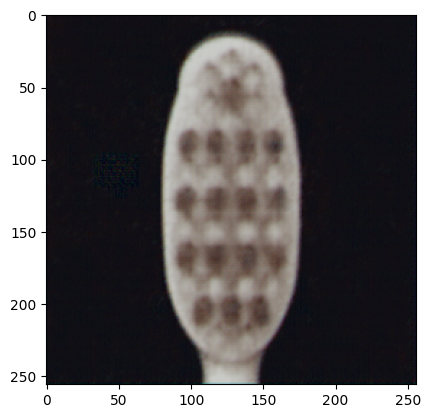

In [8]:
with torch.no_grad():
    plt.imshow(reconstructions[5].cpu().numpy()[0].transpose(1, 2, 0), cmap='gray')

In [9]:
_ = model.train(False)

torch.save(model.state_dict(), f'./VT_AE_Mvtech.pt')

# Loading saved model and testing it

In [18]:
model = VT_AE(patch_size=32).cuda()

model.load_state_dict(torch.load(f'../vit_models/vit_toothbrush.pt'))

<All keys matched successfully>

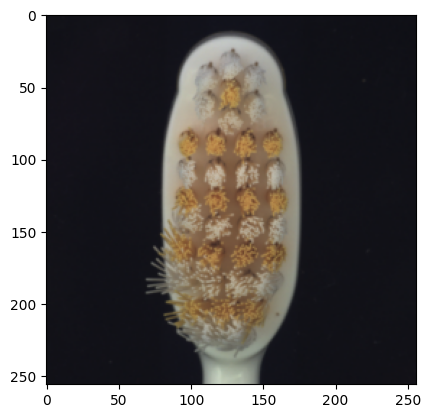

In [11]:
train_loader, test_loader = read_data('toothbrush')

test_image, mask = test_loader.dataset.__getitem__(25)

test_image = test_image.unsqueeze(0).cuda()

plt.imshow(test_image.cpu().numpy()[0].transpose(1, 2, 0))

In [16]:
SSIM = StructuralSimilarityIndexMeasure(data_range=1.0, return_full_image=True).cpu()

encoded, reconstruction = model(test_image)

mse = F.mse_loss(reconstruction, test_image, reduction='mean')
ssim_value, ssim_map = SSIM(test_image.cpu(), reconstruction.cpu())

mse.item(), ssim_value.item()

(0.0024923644959926605, 0.8250851631164551)

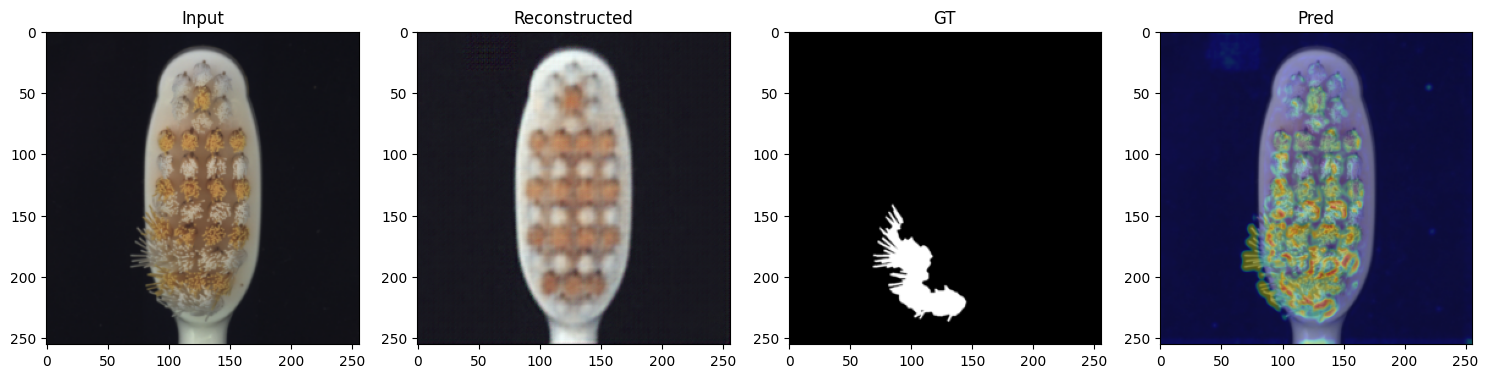

In [17]:
with torch.no_grad():
    _input_image = test_image.cpu().numpy()[0].transpose(1, 2, 0)
    _mask = mask.cpu().numpy().transpose(1, 2, 0)
    _ssim_map = ssim_map.cpu().numpy()[0][0]

    # Normalize the SSIM map
    ssim_map_norm = (_ssim_map - _ssim_map.min()) / (_ssim_map.max() - _ssim_map.min())
    # Create a heatmap from the normalized SSIM map
    heatmap = cv2.applyColorMap((ssim_map_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Convert _input_image to uint8
    _input_image_uint8 = _input_image_uint8 = (_input_image * 255).astype(np.uint8)

    # Overlay the heatmap on the original input image
    overlay = cv2.addWeighted(_input_image_uint8, 0.7, heatmap, 0.3, 0)

    # Plot the results

    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(141)
    ax1.imshow(_input_image, cmap='gray')
    ax1.set_title('Input')
    
    reconstruction_norm = (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
    
    ax2 = fig.add_subplot(142)
    ax2.imshow(reconstruction_norm.cpu().numpy()[0].transpose(1, 2, 0))
    ax2.set_title('Reconstructed')
    
    ax3 = fig.add_subplot(143)
    ax3.imshow(_mask, cmap='gray')
    ax3.set_title('GT')
    
    ax4 = fig.add_subplot(144)
    ax4.imshow(overlay)
    ax4.set_title('Pred')
    
    plt.tight_layout()
    plt.show()

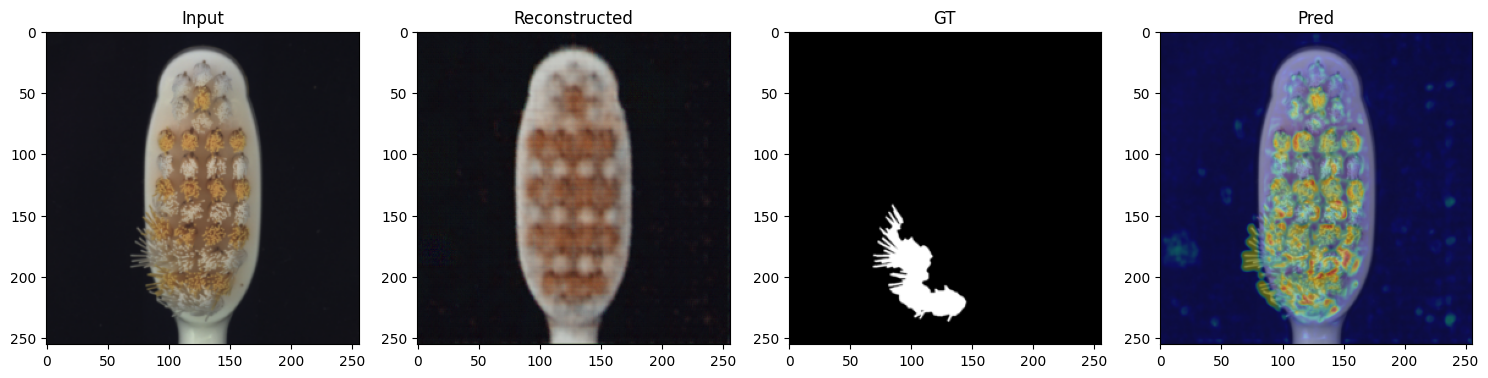